Use this IPython notebook on [Google Colaboratory](https://colab.research.google.com) to reproduce the video here:

> SSD Tensorflow based car detection and tracking demo for OSSDC.org VisionBasedACC PS3/PS4 simulator

> https://youtu.be/dqnjHqwP68Y

Code here:

> https://github.com/OSSDC/OSSDC-VisionBasedACC

Make sure you enable GPU in Colaboratory using menu path Runtime -> Change runtime type

Join our efforts in [Open Source Self Driving Car Initiative](http://OSSDC.org)!



In [0]:
# clean up to have a clean start
!rm -rf *
!ls 

In [0]:
#install opencv and other packages
!apt-get -qq install -y libsm6 libxext6
!pip install -q -U opencv-python
!pip install -q -U pafy 
!pip install -q -U imtools
!pip install -q -U youtube-dl
!pip install -q -U imutils

In [0]:
import requests
# fetch source code
def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None
    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    
# https://drive.google.com/open?id=1A6S62ce2g9jILWC_jenoVydVZLDENDIV
file_id = "1A6S62ce2g9jILWC_jenoVydVZLDENDIV"
destination = "./demo.zip"    
download_file_from_google_drive(file_id, destination)

In [4]:
# put the program in the right place
!unzip -qq demo.zip
!rm demo.zip
!rm -rf sfm __pycache__ checkpoints ssd
!mv demo/* ./
!rm -rf demo
!ls

import sys
if '/content' not in sys.path:
  sys.path.append('./')
if '/content/ssd' not in sys.path:  
  sys.path.append('./ssd')
if '/content/sfm' not in sys.path:    
  sys.path.append('./sfm')
  
print(sys.path)

checkpoints  demo_common.py  sfm  ssd
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/content/.ipython', './', './ssd', './sfm']


In [5]:
#import sys
import os
import time
import subprocess
import platform
import socket

import math
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib

import PIL.Image as pil

import cv2

from imutils.video import WebcamVideoStream
%pylab inline 
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [0]:
import demo_common as dc

# SSD specific
from ssd.nets import ssd_vgg_300, ssd_common, np_methods
from ssd.preprocessing import ssd_vgg_preprocessing
import ssd.visualization as visualization

# SfMLearner specific
from sfm.SfMLearner import SfMLearner
from sfm.utils import normalize_depth_for_display


In [7]:
#Print out some system info
print('Python version: {}'.format(platform.python_version()))
print('Tensorflow version: {}'.format(tf.__version__))
platform.platform() # get OS info
# get CPU/GPU info
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if x.device_type == 'GPU' or 'CPU'])

Python version: 3.6.3
Tensorflow version: 1.4.1
['/device:CPU:0', '/device:GPU:0']


In [0]:
#  Configuration / Global variables
slim = tf.contrib.slim
precision = 10 # where is this one being use?

webcam=False # True for using webcam, False for using a mp4

skip=0

#SKIP_EVERY=0
SKIP_EVERY=150  #pick a frame every 5 seconds

count=1000 #look only at first 1000 frames
every=SKIP_EVERY

showImage=True # True for showing image in the notebook

streamImage= False #True #True for streaming output to your PC, with ffplay as receiver
IP_ADDR = '127.0.0.1' # client ffplay client IP address

processImage=True

zoomImage=0

record = False #True to get a video with detections marked in place

# for SSD (big image)
#procWidth = 1280   # processing width (x resolution) of frame
#procHeight = 720   # processing width (Y resolution) of frame

# for SFM & SSD together
procWidth = 416
procHeight = 128


#A smooth drive in The Crew on PS4 - OSSDC Simulator ACC Train 30fps
url = 'https://www.youtube.com/watch?v=uuQlMCMT71I'

"""
if USE_CPU_ONLY:
    isess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
    sfm_sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
else:
    # TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
    gpu_options = tf.GPUOptions(allow_growth=True)
    config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
    isess = tf.InteractiveSession(config=config)
    sfm_sess = tf.InteractiveSession(config=config) # for sfm
"""
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
data_format = 'NCHW'


## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [9]:
ssd_graph = tf.Graph()
with ssd_graph.as_default():
  isess = tf.InteractiveSession(config=config)
  
  # Input placeholder
  net_shape = (300, 300)

  img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
  # Evaluation pre-processing: resize to SSD net shape.
  image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
      img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
  image_4d = tf.expand_dims(image_pre, 0)

  # Define the SSD model.
  reuse = tf.AUTO_REUSE # True if 'ssd_net' in locals() else None
  ssd_net = ssd_vgg_300.SSDNet()
  with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
      predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

  # Restore SSD model.
  ckpt_filename = './checkpoints/ssd_300_vgg.ckpt'
  #isess.run(tf.global_variables_initializer())
  saver = tf.train.Saver()
  saver.restore(isess, ckpt_filename)

  # SSD default anchor boxes.
  ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ./checkpoints/ssd_300_vgg.ckpt


In [10]:
# SfM stuff goes here
sfm_graph = tf.Graph()
with sfm_graph.as_default():
  sfm_sess = tf.InteractiveSession(config=config)
  sfm = SfMLearner()
  sfm.setup_inference(procHeight, procWidth, mode='depth')
  
  sfm_ckpt_file = './sfm/models/model-190532'
  sfm_saver = tf.train.Saver([var for var in tf.model_variables()]) 
  sfm_saver.restore(sfm_sess, sfm_ckpt_file)
  
  
  

INFO:tensorflow:Restoring parameters from ./sfm/models/model-190532


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [0]:
# Main image processing routine.
def ssd_process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    with ssd_graph.as_default():
      
      rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                                feed_dict={img_input: img})

      # Get classes and bboxes from the net outputs.
      rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
              rpredictions, rlocalisations, ssd_anchors,
              select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)

      rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
      rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
      rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
      # Resize bboxes to original image shape. Note: useless for Resize.WARP!
      rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
      return rclasses, rscores, rbboxes

In [12]:
start_time = time.time()

!rm video-test.mp4

if "youtube." in url: 
    videoUrl = dc.getVideoURL(url)
    !wget -q -O video-test.mp4 '$videoUrl' #streaming directly doesn't work in Colaboratory yet, need to save the file on disk first
else:
    videoUrl = url

print("videoUrl =",videoUrl)
videoUrl='video-test.mp4'

rm: cannot remove 'video-test.mp4': No such file or directory
1280x720
videoUrl = https://r5---sn-p5qs7n7e.googlevideo.com/videoplayback?id=o-AO86ykiJE1vEWTvGa2svOWGgocskfKa-wc6KE28__eds&ei=arKBWt2UAojpqQWV-qz4CQ&sparams=dur%2Cei%2Cid%2Cip%2Cipbits%2Citag%2Clmt%2Cmime%2Cmm%2Cmn%2Cms%2Cmv%2Cpl%2Cratebypass%2Crequiressl%2Csource%2Cexpire&expire=1518470858&itag=22&ipbits=0&ip=35.196.92.116&mime=video%2Fmp4&fvip=5&source=youtube&ms=au%2Crdu&mt=1518449162&mv=m&pl=20&c=WEB&requiressl=yes&signature=3B87C9E0281C13EE2AB3C5FA458FE64B90366A49.41C5F387E5310E10C9E281E02DB2C01739F34CC8&lmt=1486247047166339&ratebypass=yes&dur=431.449&mm=31%2C29&mn=sn-p5qs7n7e%2Csn-5uaeznl6&key=yt6


NameError: ignored

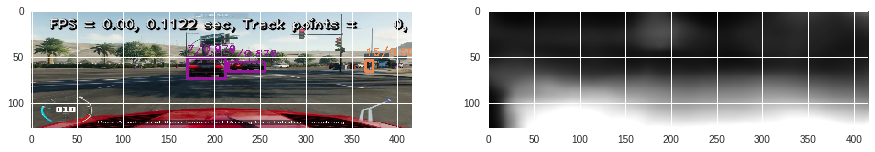

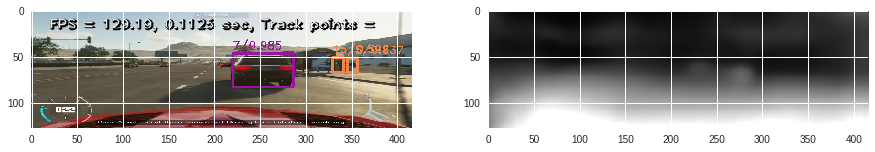

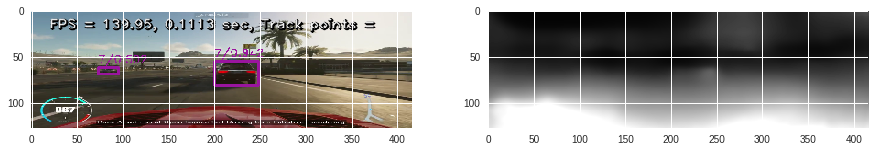

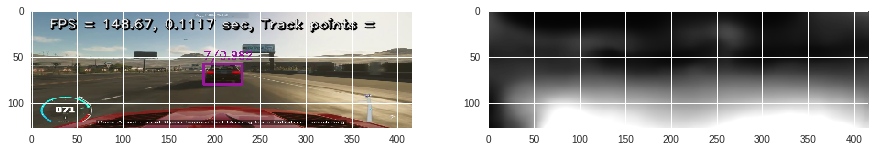

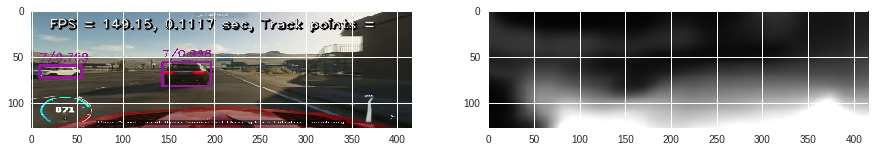

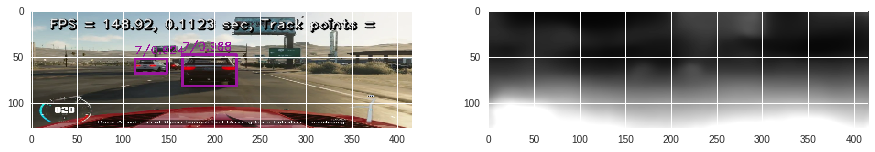

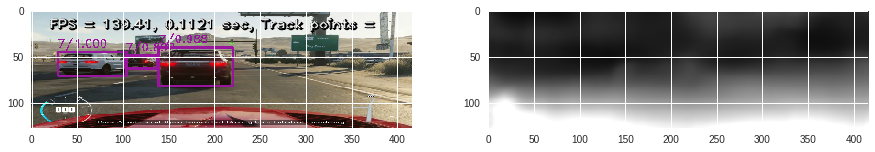

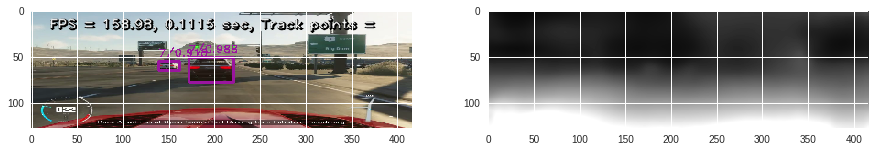

In [14]:
if webcam:
    cap = WebcamVideoStream(videoUrl).start()
else:
    cap = cv2.VideoCapture(videoUrl)

initial_time = dc.getCurrentClock()
flag=True

frameCnt=0
prevFrameCnt=0
prevTime=dc.getCurrentClock()

rclasses = []
rscores = []
rbboxes = []

if streamImage:
  #on server run this command:
  #ffplay -f mjpeg tcp://0.0.0.0:45654?listen
  clientsocket=socket.socket(socket.AF_INET,socket.SOCK_STREAM)
  clientsocket.connect(('put_your_target_ip_here',45654)) #the target ip is where the ffplay is listening

out = None
if record:
    fourcc = cv2.VideoWriter_fourcc(*'MPEG')
    timestr = time.strftime("%Y%m%d-%H%M%S")
    out = cv2.VideoWriter('output-'+timestr+'.mp4',fourcc, 30.0, (int(procWidth),int(procHeight)))

frame = cap.read()

fpsValue=0
tracks=[]

print("Start procesing!",frame)
try:
    while True:
        if webcam or cap.grab():
            if webcam:
                frame = cap.read()
            else:
                flag, frame = cap.retrieve()    
            if not flag:
                continue
            else:
                #print("frameCnt:",frameCnt)
                frame = cv2.resize(frame,(int(procWidth),int(procHeight)))
                frameCnt=frameCnt+1
                nowMicro = dc.getCurrentClock()
                delta = (nowMicro-prevTime).total_seconds()
                #print("%f " % (delta))
                if delta>=1.0:
                    fpsValue = ((frameCnt-prevFrameCnt)/delta) 
                    #print("FPS = %0.4f" % ((frameCnt-prevFrameCnt)/delta))
                    prevTime = nowMicro
                    prevFrameCnt=frameCnt

                if skip>0:
                    skip=skip-1
                    continue

                if every>0:
                    every=every-1
                    continue
                every=SKIP_EVERY

                count=count-1
                if count==0:
                    break

                img = frame
                if processImage:    
                    if zoomImage>0:
                        #crop center of image, crop width is output_side_length
                        output_side_length = int(procWidth/zoomImage)
                        height, width, depth = frame.shape
                        #print (height, width, depth)
                        height_offset = int((height - output_side_length) / 2)
                        width_offset = int((width - output_side_length) / 2)
                        #print (height, width, depth, height_offset,width_offset,output_side_length)
                        img = frame[height_offset:height_offset + output_side_length,width_offset:width_offset + output_side_length]

                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    start_time = dc.getCurrentClock()
                    
                    # SSD object detection
                    rclasses, rscores, rbboxes = ssd_process_image(img)
                    
                    # SfM depth estimation
                    with sfm_graph.as_default():                      
                      crop_img_resize = cv2.resize(img, (416, 128), interpolation = cv2.INTER_AREA)
                      pred = sfm.inference(crop_img_resize[None,:,:,:], sfm_sess, mode='depth')                    
                      depth = normalize_depth_for_display(pred['depth'][0,:,:,0])

                    if len(rclasses)>0:
                        nowMicro = dc.getCurrentClock()
                        print("# %s - %s - %0.4f seconds ---" % (frameCnt,rclasses.astype('|S3'), (nowMicro - start_time).total_seconds()))
                        dc.draw_str(img, (20, 20), "FPS = %3.2f, %0.4f sec, Track points = %5d, Frame = %6d" % (fpsValue,(nowMicro - start_time).total_seconds(),len(tracks), frameCnt))
                        start_time = nowMicro

                    visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
                      
                if showImage:
                    # for sfm stuff
                    figure(figsize=(15,15))
                    subplot(1,2,1); imshow(img)
                    subplot(1,2,2); imshow(depth)        
                    
                    if count % 3: #increase or decrease this to clear after more or less frames
                      # Display the frame until new frame is available
                      clear_output(wait=True)
                if streamImage:
                    if processImage:
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    data = cv2.imencode('.jpg', img)[1].tobytes()
                    clientsocket.send(data)
                if record:
                    if processImage:
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    newimage = cv2.resize(img,(procWidth,procHeight))
                    out.write(newimage)
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    print ("Released Video Resource")
    
nowMicro = dc.getCurrentClock()
print("# %s -- %0.4f seconds - FPS: %0.4f ---" % (frameCnt, (nowMicro - initial_time).total_seconds(), frameCnt/(nowMicro - initial_time).total_seconds()))

# clean up here

cap.release()
if record:
    out.release()
if streamImage:
    clientsocket.close()
    
    
ssd_sess.close()
isess.close()
sfm_sess.close()

In [0]:
!ls -la
!pwd